### Load Dependencies

In [9]:
import requests
import json
from datetime import datetime, timedelta
import os
from unittest.mock import patch
import boto3
from multi_x_serverless.common.constants import GLOBAL_TIME_ZONE

### Some constants

In [18]:
# Define locations
locations = {
    "us-east-1": (37.4315734, -78.6568942),
    "us-west-1": (38.8375215, -120.8958242),
    "us-west-2": (43.8041334, -120.5542012),
}

start_date = datetime(2023, 12, 1, 0, 0, 0, tzinfo=GLOBAL_TIME_ZONE)

end_date = datetime(2023, 12, 31, 0, 0, 0, tzinfo=GLOBAL_TIME_ZONE)

### Load Carbon Data

In [11]:
# Function to query the API
def query_api(start, end, lat, lon, token):
    url = f"https://api-access.electricitymaps.com/free-tier/carbon-intensity/past-range?lat={lat}&lon={lon}&start={start}&end={end}"
    headers = {"auth-token": token}
    response = requests.get(url, headers=headers, timeout=10)
    if response.status_code == 200:
        return response.json()["data"]
    else:
        print(f"Error querying API: {response.status_code}")
        return []

def run():
    actual_end_date = end_date + timedelta(days=1) # Add 1 day to the end date to make sure we include the end date
    for location, (latitude, longitude) in locations.items():
        current_start = start_date - timedelta(days=7) # Start 7 days before the start date
        combined_data = []

        while current_start < actual_end_date:
            current_end = current_start + timedelta(days=10)
            if current_end > actual_end_date:
                current_end = actual_end_date
            formatted_start = current_start.strftime("%Y-%m-%dT%H:%M:%SZ")
            formatted_end = current_end.strftime("%Y-%m-%dT%H:%M:%SZ")
            data = query_api(
                formatted_start, formatted_end, latitude, longitude, os.environ.get("ELECTRICITY_MAPS_AUTH_TOKEN")
            )
            combined_data.extend(data)
            current_start = current_end

        # Save the combined data to a file
        output_file = f"./data/carbon/{location}_carbon_data.json"
        with open(output_file, "w") as f:
            json.dump(combined_data, f)

        print(f"Data combined and saved to {output_file}")


if __name__ == "__main__":
    run()

Data combined and saved to ./data/carbon/us-east-1_carbon_data.json
Data combined and saved to ./data/carbon/us-west-1_carbon_data.json
Data combined and saved to ./data/carbon/us-west-2_carbon_data.json


#### Optional: Plot carbon intensity of regions

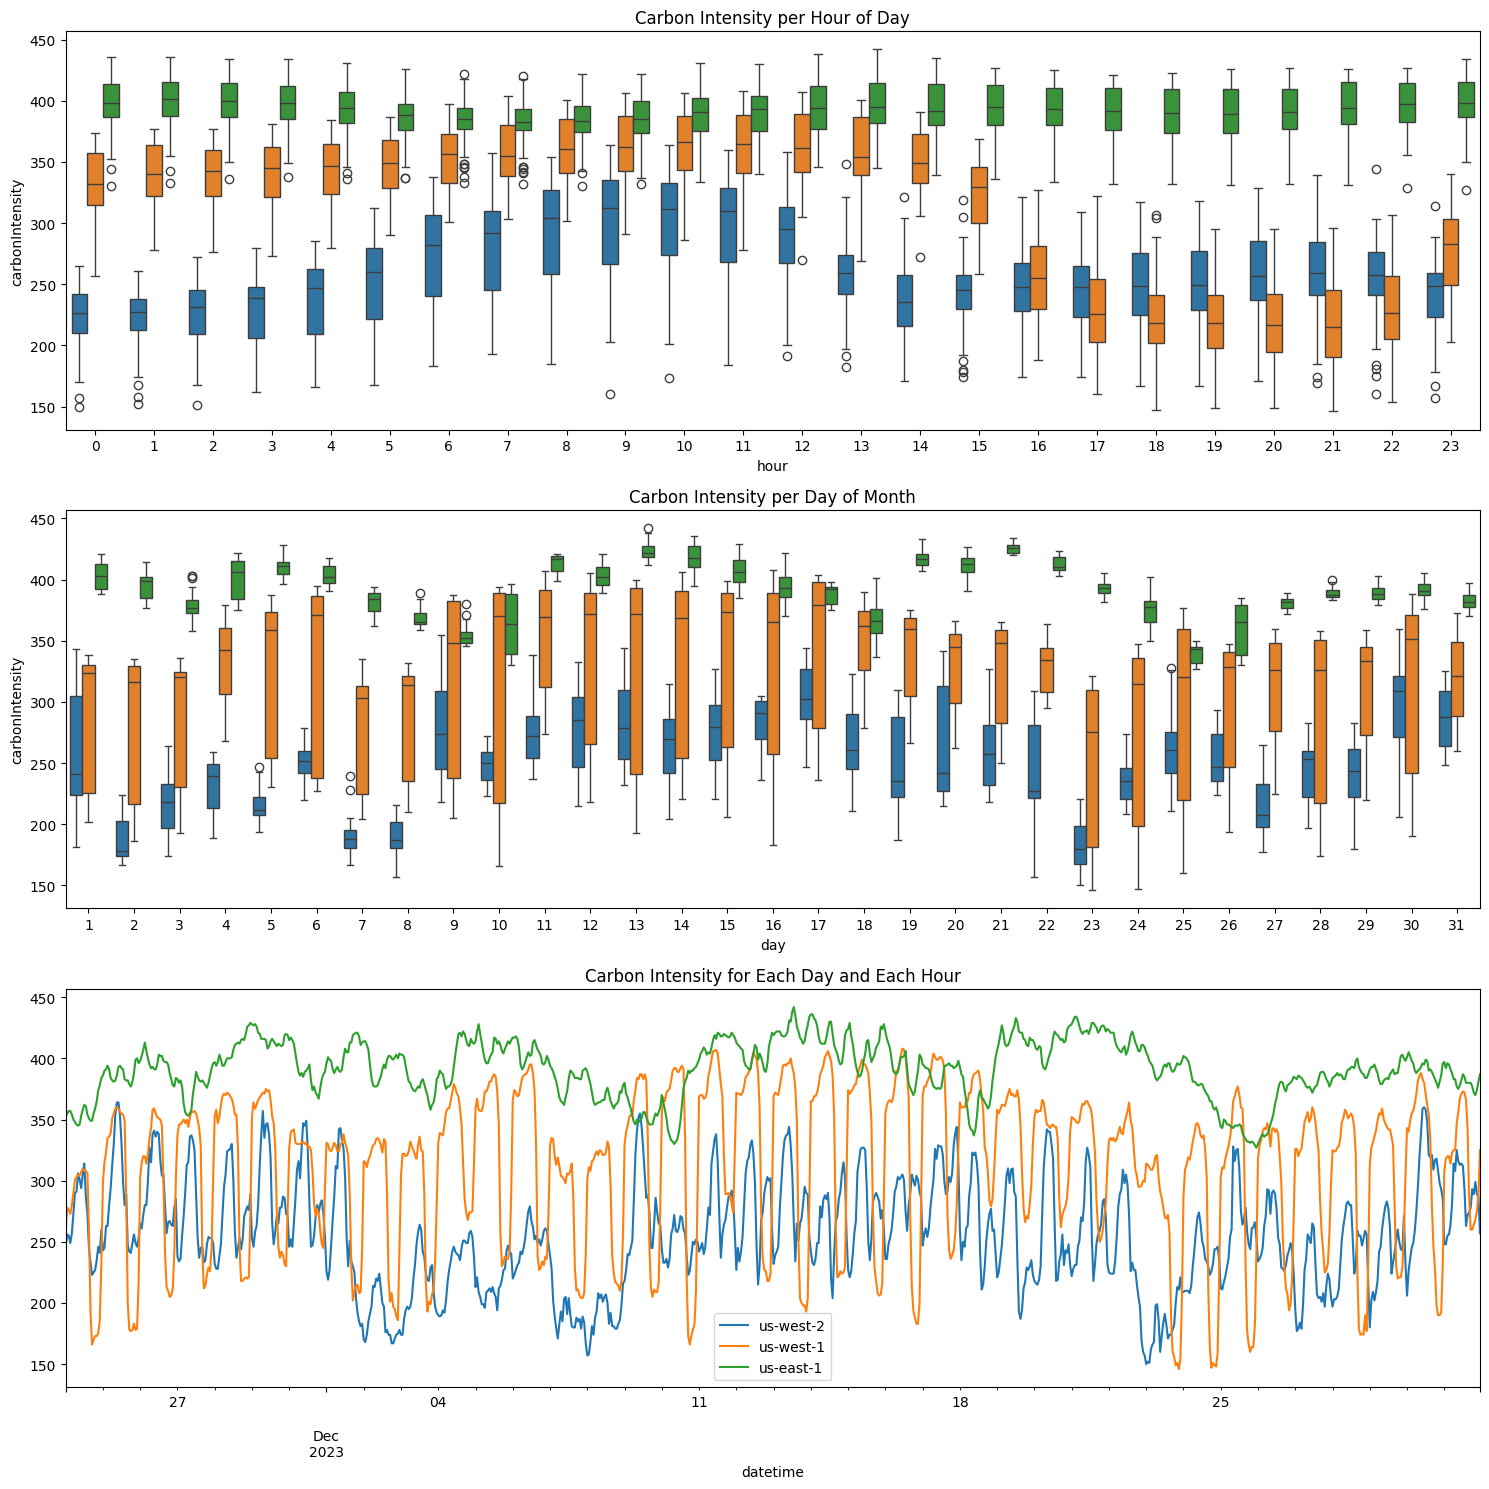

In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Create one dataframe for all the data
all_data = pd.DataFrame()

# Order the data by location
locations_ordered = ["us-west-2", "us-west-1", "us-east-1"]

for location in locations_ordered:
    with open(f"./data/carbon/{location}_carbon_data.json", "r") as f:
        data = json.load(f)
        
    df = pd.DataFrame(data)

    df["location"] = location

    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month

    all_data = pd.concat([all_data, df])

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Create a boxplot of carbon intensity per hour of day for each location
sns.boxplot(x='hour', y='carbonIntensity', hue='location', data=all_data, ax=axes[0])
axes[0].set_title('Carbon Intensity per Hour of Day')
axes[0].get_legend().remove()

selected_all_data_for_month = all_data[(all_data['datetime'] >= start_date) & (all_data['datetime'] <= end_date + timedelta(days=1))]

# Create a boxplot of carbon intensity per day of month for each location
sns.boxplot(x='day', y='carbonIntensity', hue='location', data=selected_all_data_for_month, ax=axes[1])
axes[1].set_title('Carbon Intensity per Day of Month')
# remove the legend
axes[1].get_legend().remove()

# Create a line plot of carbon intensity for each day and each hour for each location
for location in locations_ordered:
    all_data[all_data['location'] == location].set_index('datetime')['carbonIntensity'].plot(ax=axes[2], label=location)
axes[2].set_title('Carbon Intensity for Each Day and Each Hour')
axes[2].legend()

plt.tight_layout()
os.makedirs(".data/plots", exist_ok=True)
included_regions_str = "_".join(locations.keys())
result_file_name = f"./data/plots/carbon_intensity_regions_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}_{included_regions_str}.png"
plt.savefig(result_file_name)

### Create Carbon Collector Logs

In [20]:
import json
import math
import os
from datetime import datetime, timedelta
from collections import defaultdict

def calculate_distance(lat1, lon1, lat2, lon2):
    r = 6371.0  # Earth radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return r * c

def process_and_store_carbon_data_for_regions(input_file, output_folder, regions_info, current_region):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output directory exists
    
    with open(input_file, 'r') as file:
        data = json.load(file)
    
    # For each day between start_date and end_date
    for day in range((end_date - start_date).days + 1):
        current_date = start_date + timedelta(days=day)

        # Get all the data for the previous 7 days
        previous_7_days_data = [entry for entry in data if datetime.strptime(entry['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ').date() >= (current_date - timedelta(days=7)).date() and datetime.strptime(entry['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ').date() < current_date.date()]

        # Calculate the average carbon intensity for the previous 7 days
        if not previous_7_days_data:
            continue
        overall_sum = sum(item['carbonIntensity'] for item in previous_7_days_data)
        overall_avg = overall_sum / len(previous_7_days_data)

        # Calculate the average carbon intensity for each hour of the day
        hourly_averages = defaultdict(list)
        for item in previous_7_days_data:
            hour = datetime.strptime(item['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ').hour
            hourly_averages[hour].append(item['carbonIntensity'])

        hourly_avg = {hour: sum(values) / len(values) for hour, values in hourly_averages.items()}

        # Calculate the distances between the regions
        transmission_distances = {
            f"aws:{region_key}": calculate_distance(regions_info[current_region][0], regions_info[current_region][1], regions_info[region_key][0], regions_info[region_key][1]) for region_key in regions_info
        }
    
        # Assemble the result dictionary
        result_dict = {
            "averages": {
                "overall": {"carbon_intensity": overall_avg},
                **{str(hour): {"carbon_intensity": avg} for hour, avg in hourly_avg.items()}
            },
            "units": "gCO2eq/kWh",
            "transmission_distances": transmission_distances
        }

        # Store the result
        day_folder = os.path.join(output_folder, current_date.strftime('%Y-%m-%d'))
        os.makedirs(day_folder, exist_ok=True)
        with open(os.path.join(day_folder, 'data.json'), 'w') as outfile:
            json.dump(result_dict, outfile, indent=4)

for region in locations:
    process_and_store_carbon_data_for_regions(f"./data/carbon/{region}_carbon_data.json", f"./data/collected_carbon/{region}", locations, region)

#### Optional: Check accuracy of the predictions made by carbon collector

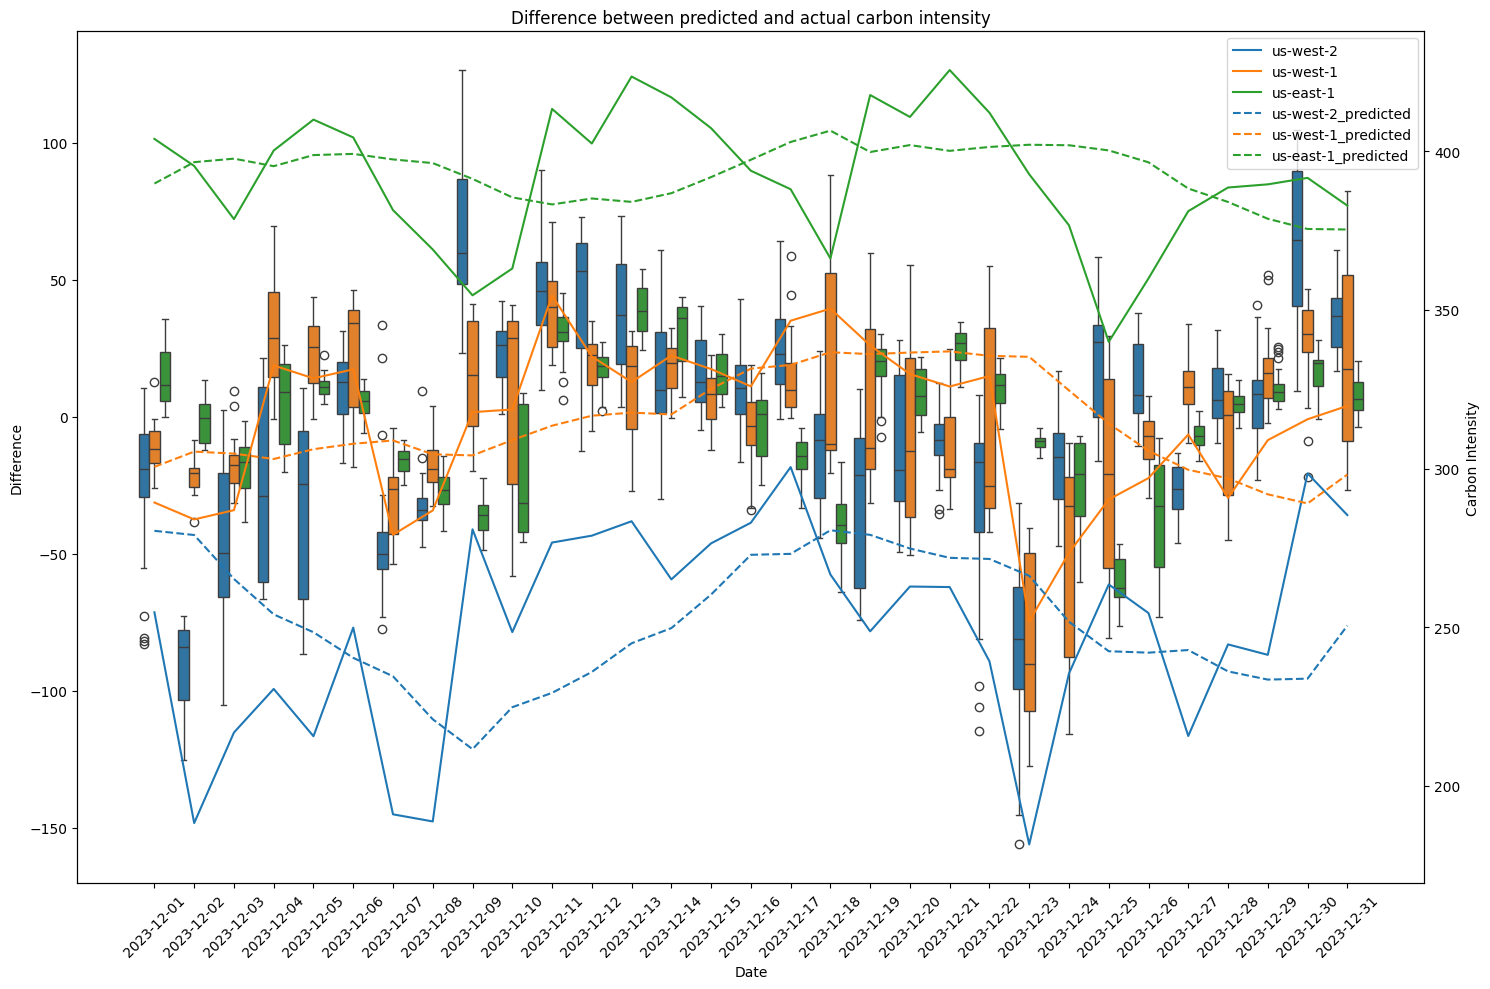

In [25]:
# Create one dataframe for all the data
all_data = pd.DataFrame()
locations_ordered = ["us-west-2", "us-west-1", "us-east-1"]

for location in locations_ordered:
    with open(f"./data/carbon/{location}_carbon_data.json", "r") as f:
        data = json.load(f)
        
    df = pd.DataFrame(data)

    df["location"] = location

    df['datetime'] = pd.to_datetime(df['datetime'])

    # filter the data to only include the dates between start_date and end_date
    df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date + timedelta(days=1))]

    # get rid of all the columns except datetime, location, and carbonIntensity
    df = df[['datetime', 'location', 'carbonIntensity']]

    all_data = pd.concat([all_data, df])

for location_dir in os.listdir("./data/collected_carbon"):
    location = location_dir.split("_")[0]
    for date_dir in os.listdir(f"./data/collected_carbon/{location_dir}"):
        with open(f"./data/collected_carbon/{location_dir}/{date_dir}/data.json", "r") as f:
            data = json.load(f)
        date = datetime.strptime(date_dir, "%Y-%m-%d").replace(tzinfo=GLOBAL_TIME_ZONE)
        if date < start_date or date > end_date:
            continue
        for hour, values in data['averages'].items():
            if hour == "overall":
                continue
            # compare the predicted value with the actual value
            predicted_value = values['carbon_intensity']
            actual_value = all_data[(all_data['location'] == location) & (all_data['datetime'].dt.date == date.date()) & (all_data['datetime'].dt.hour == int(hour))]['carbonIntensity']
            if actual_value.empty:
                raise ValueError(f"No data for {location} on {date} at {hour}h")
            if len(actual_value) > 1:
                raise ValueError(f"Multiple values for {location} on {date} at {hour}h")
            actual_value = actual_value.iloc[0]

            # calculate the difference
            difference = actual_value - predicted_value

            # store the difference in the dataframe
            all_data.loc[(all_data['location'] == location) & (all_data['datetime'].dt.date == date.date()) & (all_data['datetime'].dt.hour == int(hour)), 'difference'] = difference

            # store the predicted value in the dataframe
            all_data.loc[(all_data['location'] == location) & (all_data['datetime'].dt.date == date.date()) & (all_data['datetime'].dt.hour == int(hour)), 'predicted'] = predicted_value

# Add a date column
all_data['date'] = all_data['datetime'].dt.date

# Create a boxplot of the differences
fig, ax1 = plt.subplots(figsize=(15, 10))
sns.boxplot(x='date', y='difference', hue='location', data=all_data, ax=ax1)

# Create a twin axis that shares the x-axis
ax2 = ax1.twinx()

# Add a line plot of the actual carbon intensity on the twin axis
for location in locations_ordered:
    # Convert 'datetime' to just date
    all_data['date_only'] = all_data['datetime'].dt.date
    # Convert 'date_only' to string and sort the data by 'date_only'
    all_data_sorted = all_data.sort_values('date_only')
    all_data_sorted['date_only'] = all_data_sorted['date_only'].astype(str)
    all_data_sorted[all_data_sorted['location'] == location].groupby('date_only')['carbonIntensity'].mean().plot(ax=ax2, label=location)

for i, location in enumerate(locations_ordered):
    # Also plot the predicted value
    # Maintain the color of the actual carbon intensity
    color = ax2.get_lines()[i].get_color()
    all_data_sorted[all_data_sorted['location'] == location].groupby('date_only')['predicted'].mean().plot(ax=ax2, label=f"{location}_predicted", linestyle="--", color=color)

# Set the title and labels
ax1.set_title('Difference between predicted and actual carbon intensity')
ax1.set_xlabel('Date')
ax1.set_ylabel('Difference')
ax2.set_ylabel('Carbon Intensity')

# remove ax-1 legend
ax1.get_legend().remove()

# add ax-2 legend
ax2.legend()

for label in ax1.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
included_regions_str = "_".join(locations.keys())
result_file_name = f"./data/plots/carbon_intensity_prediction_differences_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}_{included_regions_str}.png"
plt.savefig(result_file_name, dpi=300)

### Get Data from the Home Region

For each benchmark:
1. Deploy the benchmark (optimally without any constraints) to the home region (which should be one of the regions we eventually also want to take into consideration).
2. Run the benchmark for a time (use the `invoke_serverless_function_uniform.sh` script to do so). I used it for example like this:
```bash
poetry run ./invoke_serverless_function_uniform.sh dna_visualization 0.0.1 200 3600
```
3. Use the following small script to log sync the data and store it locally.

In [3]:
# Define the benchmarks:
benchmarks = ["dna_visualization-0.0.2"]

benchmark_input_data = {
    "dna_visualization-0.0.2": '{"gen_file_name": "small_sequence.gb"}'
}

benchmark_to_start_hop_instance = {
    "dna_visualization-0.0.2": "dna_visualization-0_0_2-GetInput:entry_point:0"
}

#### Log Sync

In [39]:
from multi_x_serverless.syncers.log_syncer import LogSyncWorkflow
from multi_x_serverless.common.models.endpoints import Endpoints
from multi_x_serverless.common.constants import DEPLOYMENT_MANAGER_RESOURCE_TABLE, GLOBAL_TIME_ZONE

region_clients = {}
endpoints = Endpoints()

# This assumes that the run happened in the last 24 hours
time_intervals = [(datetime.now(GLOBAL_TIME_ZONE) - timedelta(days=1), datetime.now(GLOBAL_TIME_ZONE))]

def log_sync(output_dir, workflow_id):
    deployment_manager_config_str = endpoints.get_deployment_manager_client().get_value_from_table(
        DEPLOYMENT_MANAGER_RESOURCE_TABLE, workflow_id
    )

    raw_data_dir = output_dir
    os.makedirs(raw_data_dir, exist_ok=True)

    def mock_upload_data(self, data_for_upload: str):
        with open(f"{raw_data_dir}/data.json", "w") as f:
            f.write(data_for_upload)

    with patch.object(LogSyncWorkflow, "_upload_data", mock_upload_data):
        log_sync_workflow = LogSyncWorkflow(
            workflow_id,
            region_clients,
            deployment_manager_config_str,
            time_intervals,
            endpoints.get_datastore_client(),
            {}
        )
        log_sync_workflow.sync_workflow()

#### Invoke Log Sync

In [5]:
for workflow_id in benchmarks:
    log_sync(f"./data/run_data/home_region/{workflow_id}", workflow_id)

#### Workflow Collect

In [40]:
from multi_x_serverless.data_collector.components.workflow.workflow_retriever import WorkflowRetriever
from multi_x_serverless.data_collector.components.data_collector import DataCollector

workflow_retriever = WorkflowRetriever(None)

def workflow_collect(input_dir, output_dir):
    with open(input_dir, "r") as f:
        data = f.read()

    workflow_summary = workflow_retriever._transform_workflow_summary(
        data,
    )

    os.makedirs(output_dir, exist_ok=True)

    with open(f"{output_dir}/data.json", "w") as f:
        json.dump(workflow_summary, f, indent=4)

#### Invoke Workflow Collect

In [5]:
for workflow_id in benchmarks:
    workflow_collect(f"./data/run_data/home_region/{workflow_id}/data.json", f"./data/collected_workflow/{workflow_id}/home_region")

### Run the Deployment Algorithm

We need to run the deployment algorithm for the days between the start and end date. We will run it every day and store the results locally in files.
Additionally, we need to provide the data collected by a specific workflow as the input to the workflow loader.

**TODO BEFORE the following is executed:** For each of the involved benchmarks we need to actually have some data from the home region. So please do **Get Data from the Home Region** first.

In [26]:
from multi_x_serverless.common.constants import GLOBAL_SYSTEM_REGION, DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE
from multi_x_serverless.routing.workflow_config import WorkflowConfig
from multi_x_serverless.routing.deployment_algorithms.stochastic_heuristic_deployment_algorithm import StochasticHeuristicDeploymentAlgorithm
from multi_x_serverless.routing.deployment_input.components.loaders.carbon_loader import CarbonLoader
from multi_x_serverless.routing.deployment_input.components.loaders.region_viability_loader import RegionViabilityLoader
from multi_x_serverless.routing.deployment_algorithms.deployment_algorithm import DeploymentAlgorithm
from multi_x_serverless.routing.deployment_input.components.loaders.workflow_loader import WorkflowLoader
from itertools import combinations

# Define the constraint configurations
constraint_configurations = {
    "no_constraints": {
        "constraints": {
            "hard_resource_constraints": {"cost": None, "runtime": None, "carbon": None},
            "soft_resource_constraints": {"cost": None, "runtime": None, "carbon": None},
            "priority_order": ["carbon", "cost", "runtime"],
        }
    },
    "five_percent_runtime_constraint": {
        "constraints": {
            "hard_resource_constraints": {"cost": None, "runtime": {"type": "relative", "value": 105}, "carbon": None},
            "soft_resource_constraints": {"cost": None, "runtime": None, "carbon": None},
            "priority_order": ["carbon", "cost", "runtime"],
        }
    },
}

defined_home_region = {"provider": "aws", "region": "us-east-1"}

location_keys = list(locations.keys())
all_combinations = [combo for r in range(1, len(location_keys)+1) for combo in combinations(location_keys, r)]

region_configurations = []

for combination in all_combinations:
    allowed_regions = [{"provider": "aws", "region": region} for region in combination]
    region_configurations.append(allowed_regions)

dynamodb_client = boto3.client('dynamodb', region_name=GLOBAL_SYSTEM_REGION)
for benchmark in benchmarks:
    response = dynamodb_client.get_item(TableName=DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE, Key={"key": {"S": benchmark}})
    item = response.get("Item")
    workflow_config_from_table = item["value"]["S"]

    workflow_config_dict = json.loads(json.loads(workflow_config_from_table).get("workflow_config"))
    for configuration_name, configuration in constraint_configurations.items():
        workflow_config_dict["constraints"] = configuration["constraints"]

        for location_configuration in region_configurations:
            workflow_config_dict["home_region"] = defined_home_region

            if workflow_config_dict["home_region"] not in location_configuration:
                workflow_config_dict["home_region"] = location_configuration[0]

            for instance in workflow_config_dict["instances"].values():
                instance["regions_and_providers"]["allowed_regions"] = location_configuration

            workflow_config = WorkflowConfig(workflow_config_dict)

            for day in range((end_date - start_date).days + 1):
                current_date = start_date + timedelta(days=day)

                def mock_carbon_loader_setup(self, available_regions: set[str]):
                    real_available_regions = list(locations.keys())
                    loaded_carbon_data = {}
                    for region in real_available_regions:
                        carbon_data_path = f'./data/collected_carbon/{region}/{current_date.strftime("%Y-%m-%d")}/data.json'
                        with open(carbon_data_path, 'r') as file:
                            loaded_carbon_data[f'aws:{region}'] = json.load(file)
                    self._carbon_data = loaded_carbon_data

                def mock_workflow_loader_setup(self, workflow_id: str):
                    collected_data_dir = f"./data/collected_workflow/{workflow_id}/home_region/data.json"

                    with open(collected_data_dir, "r") as f:
                        self._workflow_data = json.load(f)

                def mock_region_viability_setup(self):
                    self._available_regions = [f'aws:{region}' for region in locations.keys()]

                def mock_upload_result(self, result: dict):
                    region_combination_str = "_".join([region["region"] for region in location_configuration])
                    result_path = f'./data/deployment_results/{benchmark}/{configuration_name}_{region_combination_str}/'
                    os.makedirs(result_path, exist_ok=True)
                    with open(os.path.join(result_path, f'{current_date.strftime("%Y-%m-%d")}.json'), 'w') as file:
                        json.dump(result, file, indent=4)

                print(f"Running {benchmark} with {configuration_name} and {location_configuration}")

                with patch.object(CarbonLoader, 'setup', new=mock_carbon_loader_setup), patch.object(RegionViabilityLoader, 'setup', new=mock_region_viability_setup), patch.object(DeploymentAlgorithm, '_upload_result', new=mock_upload_result), patch.object(WorkflowLoader, 'setup', new=mock_workflow_loader_setup):
                    algorithm = StochasticHeuristicDeploymentAlgorithm(workflow_config)
                    algorithm.run([f"{i}" for i in range(24)])

                if len(location_configuration) == 1:
                    break

Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-east-1'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-west-1'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-west-2'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-east-1'}, {'provider': 'aws', 'region': 'us-west-1'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-east-1'}, {'provider': 'aws', 'region': 'us-west-1'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-east-1'}, {'provider': 'aws', 'region': 'us-west-1'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-east-1'}, {'provider': 'aws', 'region': 'us-west-1'}]
Running dna_visualization-0.0.2 with no_constraints and [{'provider': 'aws', 'region': 'us-east-1'}, {'provider': 'aw

#### How are we shifting over time?

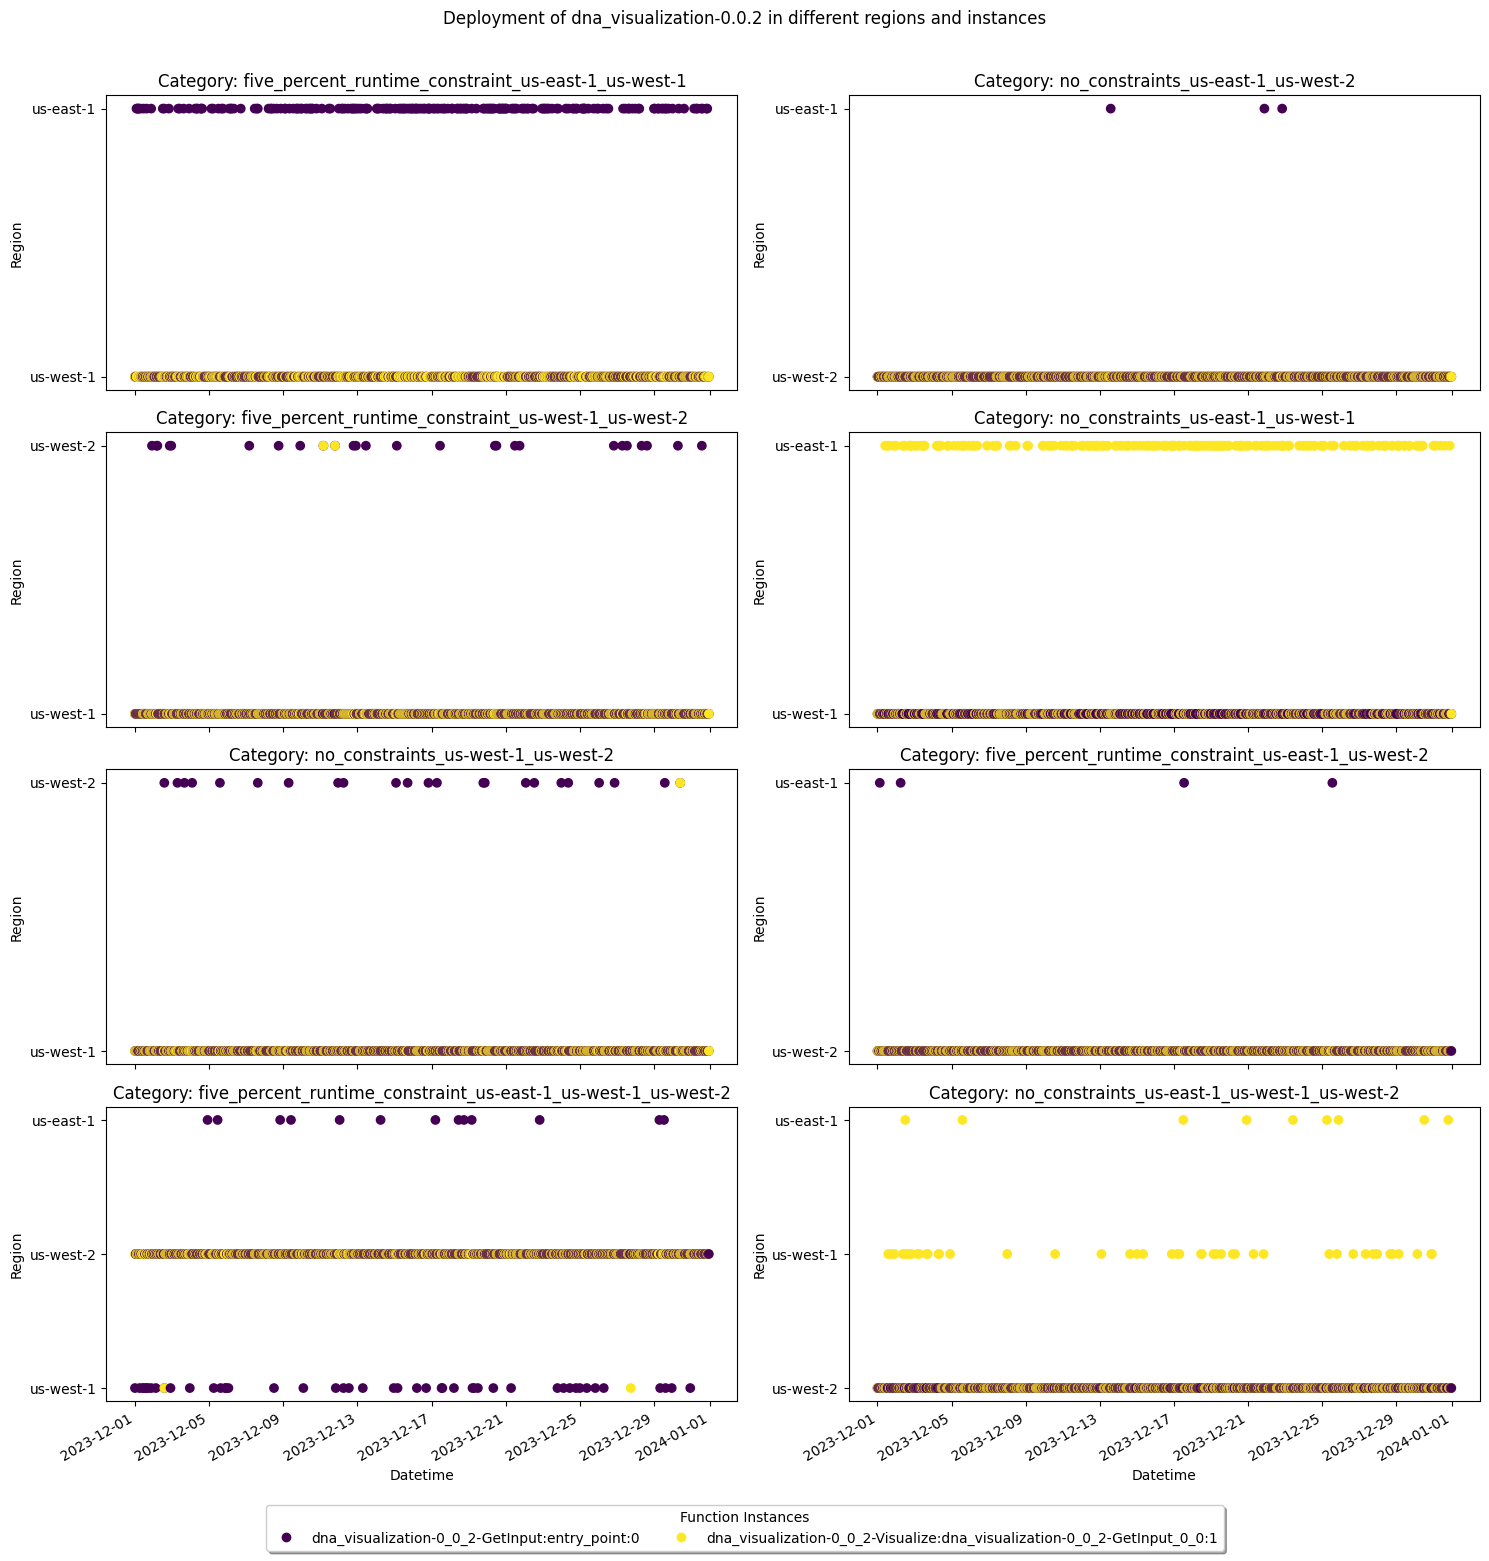

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

workflow_id = "dna_visualization-0.0.2"

deployment_result_path = f'./data/deployment_results/{workflow_id}'

all_data_list = []

# Iterate over all results, retrieving the combinations of instances and regions
for directory in os.listdir(deployment_result_path):
    if not os.path.isdir(os.path.join(deployment_result_path, directory)):
        continue

    # If there is only one file in the directory, it means that there is only one region, skip
    if len(os.listdir(os.path.join(deployment_result_path, directory))) == 1:
        continue

    for file in os.listdir(os.path.join(deployment_result_path, directory)):
        day_date = file.split(".")[0]

        day_datetime = datetime.strptime(day_date, "%Y-%m-%d").replace(tzinfo=GLOBAL_TIME_ZONE)

        if day_datetime < start_date or day_datetime > end_date:
            continue

        with open(os.path.join(deployment_result_path, directory, file), 'r') as f:
            data = json.load(f)

        for time_key, deployment in data["time_keys_to_staging_area_data"].items():
            for instance, provider_region in deployment.items():
                region = provider_region["provider_region"]["region"]

                all_data = all_data_list.append({
                    "datetime": day_datetime + timedelta(hours=int(time_key)),
                    "function_instance": instance,
                    "region": region,
                    "category": directory
                })

all_data = pd.DataFrame(all_data_list)
all_data['datetime'] = pd.to_datetime(all_data['datetime'])
all_data.sort_values(by='datetime', inplace=True)

# Get unique categories
categories = all_data['category'].unique()
unique_instances = pd.unique(all_data['function_instance'])

# Determine the layout of the subplots
n = len(categories)
cols = 2  # Adjust the number of columns per row
rows = n // cols + (n % cols > 0)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, rows*4), squeeze=False)  # Adjust figsize as needed

for i, category in enumerate(categories):
    ax = axs[i//cols, i%cols]  # Determine the subplot location
    category_data = all_data[all_data['category'] == category]
    
    # Create a scatter plot for the current category
    scatter = ax.scatter(category_data['datetime'], category_data['region'], 
                         c=pd.factorize(category_data['function_instance'])[0])
    
    ax.set_title(f'Category: {category}')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Region')
    
    # rotate the x-ticks
    #ax.set_xticklabels(category_data['datetime'].dt.date.unique(), rotation=45)

    # Improve readability of x-axis dates
    ax.figure.autofmt_xdate()  # Automatically format x-axis dates

# Adjust layout to prevent overlap
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_instances)))
custom_legend = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in colors]
fig.legend(custom_legend, unique_instances, title="Function Instances", loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# If you have an odd number of categories and subplots, you may want to hide the last subplot if it's unused
if n % cols > 0:
    axs[-1, -1].axis('off')

plt.suptitle(f"Deployment of {workflow_id} in different regions and instances")

unique_regions = all_data['region'].unique()

included_regions_str = "_".join(unique_regions)
result_file_name = f"./data/plots/shifting_decisions_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}_{included_regions_str}_{workflow_id}.png"

plt.savefig(result_file_name, dpi=300)


### Run new experiments for the new deployments

Now since we have the new deployments, we can run the experiments for them. We don't need to run all experiments, basically we need to run all the combinations of the regions involved. For this we need to iterate over the potential deployments, find combinations of regions that are not yet collected and run the experiments for them. The following script will do this on a per benchmark basis.

In [29]:
# Choose which benckmark to run
workflow_id = benchmarks[0]

#### Get unique new deployments for this benchmark

In [35]:
deployment_result_path = f'./data/deployment_results/{workflow_id}'

unique_instance_region_combinations = set()

# Iterate over all results, retrieving the combinations of instances and regions
for directory in os.listdir(deployment_result_path):
    if not os.path.isdir(os.path.join(deployment_result_path, directory)):
        continue
    for file in os.listdir(os.path.join(deployment_result_path, directory)):
        with open(os.path.join(deployment_result_path, directory, file), 'r') as f:
            data = json.load(f)
        for time_key, deployment in data["time_keys_to_staging_area_data"].items():
            deployment_str = json.dumps(deployment)
            unique_instance_region_combinations.add(deployment_str)

# Store the unique combinations
with open(f'./data/deployment_results/{workflow_id}/unique_instance_region_combinations.json', 'w') as f:
    json.dump(list(unique_instance_region_combinations), f, indent=4)

#### Re-deploy all deployments

Before we can run the experiments we need the code to be in the right regions


In [6]:
from multi_x_serverless.deployment.common.deploy.deployer import create_default_deployer
from multi_x_serverless.common.constants import (
    DEPLOYMENT_MANAGER_RESOURCE_TABLE
)
from multi_x_serverless.deployment.server.re_deployment_server import ReDeploymentServer
from multi_x_serverless.deployment.common.factories.deployer_factory import DeployerFactory
from multi_x_serverless.common.models.endpoints import Endpoints

endpoints = Endpoints()

deployment_result_path = f'./data/deployment_results/{workflow_id}/unique_instance_region_combinations.json'

workflow_data_raw = endpoints.get_deployment_manager_client().get_value_from_table(
    DEPLOYMENT_MANAGER_RESOURCE_TABLE, workflow_id
)

workflow_data = json.loads(workflow_data_raw)

workflow_function_descriptions = json.loads(workflow_data["workflow_function_descriptions"])
deployment_config = json.loads(workflow_data["deployment_config"])
deployed_regions = json.loads(workflow_data["deployed_regions"])

deployer_factory = DeployerFactory(project_dir=None)
config = deployer_factory.create_config_obj_from_dict(deployment_config=deployment_config)
deployer = create_default_deployer(config)

re_redployment_server = ReDeploymentServer(workflow_id)

with open(deployment_result_path, 'r') as f:
    unique_instance_region_combinations = json.load(f)

for combination in unique_instance_region_combinations:
    deployment = json.loads(combination)

    deployer.re_deploy(
        workflow_function_descriptions,
        deployed_regions,
        deployment
    )

re_redployment_server._upload_new_deployed_regions(deployed_regions)

Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
2024/03/18 11:42:45 logged in via /Users/viktorgsteiger/.docker/config.json
2024/03/18 11:42:45 Copying from 485595969306.dkr.ecr.us-east-1.amazonaws.com/dna_visualization-0_0_2-getinput_aws-us-east-1:latest to 485595969306.dkr.ecr.us-west-1.amazonaws.com/dna_visualization-0_0_2-getinput_aws-us-west-1:latest
2024/03/18 11:42:47 pushed blob: sha256:f3d4198225085ff882381ef2b6626c18d822659db3dd9fa97cec79283dabde53
2024/03/18 11:42:47 pushed blob: sha256:410d97f1013b0e56c8a24e5a95517c536d5cad71829d982813a28e1a1b8ec82f
2024/03/18 11:42:48 pushe

#### Define constants for the experiments

In [36]:
number_of_invocations = 100
time_frame_seconds = 60 * 10 # 10 minutes

# Calculate the sleep time between each invocation
sleep_time = time_frame_seconds / number_of_invocations

#### Run actual experiments

In [37]:
from multi_x_serverless.common.models.endpoints import Endpoints
from multi_x_serverless.common.constants import (
    WORKFLOW_PLACEMENT_DECISION_TABLE,
    DEPLOYMENT_MANAGER_RESOURCE_TABLE,
    TIME_FORMAT,
    GLOBAL_TIME_ZONE
)
from multi_x_serverless.endpoint.client import Client
from multi_x_serverless.common.models.remote_client.remote_client_factory import RemoteClientFactory
import time

deployment_result_path = f'./data/deployment_results/{workflow_id}/unique_instance_region_combinations.json'

with open(deployment_result_path, 'r') as f:
    unique_instance_region_combinations = json.load(f)

endpoints = Endpoints()

deployed_region_information = endpoints.get_deployment_manager_client().get_value_from_table(
    DEPLOYMENT_MANAGER_RESOURCE_TABLE, workflow_id
)

deployed_regions = json.loads(json.loads(deployed_region_information)["deployed_regions"])

current_workflow_placement_raw = endpoints.get_deployment_algorithm_workflow_placement_decision_client().get_value_from_table(
    WORKFLOW_PLACEMENT_DECISION_TABLE, workflow_id
)

current_workflow_placement = json.loads(current_workflow_placement_raw)

current_workflow_placement["send_to_home_region"] = True

client = Client(workflow_id)

def instance_to_function_name(provider_region, instance_name):
    return (
        instance_name.split(":", maxsplit=1)[0]
        + "_"
        + provider_region["provider"]
        + "-"
        + provider_region["region"]
    )

for combination_raw in unique_instance_region_combinations:
    deployment = json.loads(combination_raw)

    # We need to override the home_deployment:
    for instance_name, instance_description in current_workflow_placement["workflow_placement"]["home_deployment"].items():
        instance_description["provider_region"] = deployment[instance_name]["provider_region"]
        function_name = instance_to_function_name(
            instance_description["provider_region"], instance_name
        )
        messaging_queue_identifier = deployed_regions[function_name]["message_topic"]
        function_identifier = deployed_regions[function_name]["function_identifier"]

        instance_description["identifier"] = messaging_queue_identifier
        instance_description["function_identifier"] = function_identifier

    provider, region, identifier = client._get_initial_node_workflow_placement_decision(
        current_workflow_placement, True
    )

    current_time = datetime.now(GLOBAL_TIME_ZONE).strftime(TIME_FORMAT)

    wrapped_input_data = {
        "input_data": benchmark_input_data[workflow_id],
        "time_request_sent": current_time,
        "workflow_placement_decision": current_workflow_placement,
    }

    json_payload = json.dumps(wrapped_input_data)

    remote_client = RemoteClientFactory.get_remote_client(provider, region)

    for i in range(number_of_invocations):
        remote_client.invoke_function(
            message=json_payload,
            identifier=identifier,
        )
        time.sleep(sleep_time)

### Replay results on carbon data

Now we have all the pieces we need. We have the deployments for a specific day under the given constraints, we have the carbon data for the same day and we have the runtime results for the specific deployments. Now we can replay the results on the carbon data and see how much carbon we would have emitted if we had deployed the functions in the way we did.

#### First we need to log sync that data into a new file

In [41]:
log_sync(f"./data/run_data/experiments/{workflow_id}", workflow_id)

In [42]:
experiments_collected_data_dir = f"./data/collected_workflow/{workflow_id}/experiments"

workflow_collect(f"./data/run_data/experiments/{workflow_id}/data.json", experiments_collected_data_dir)

#### Something weird is going on with the execution latencies

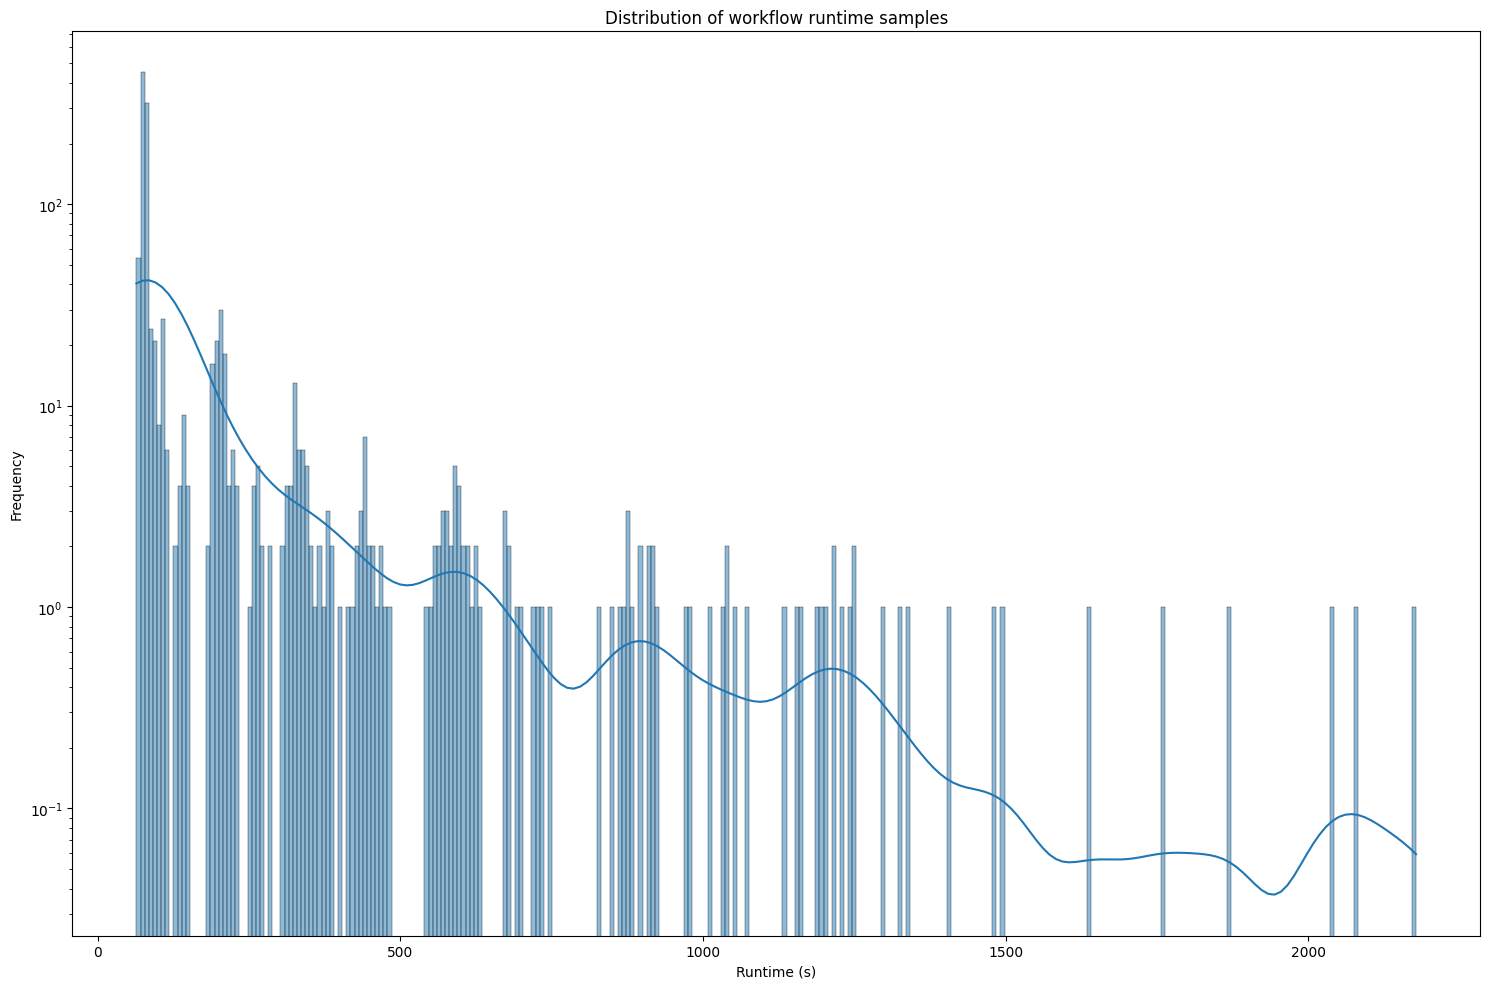

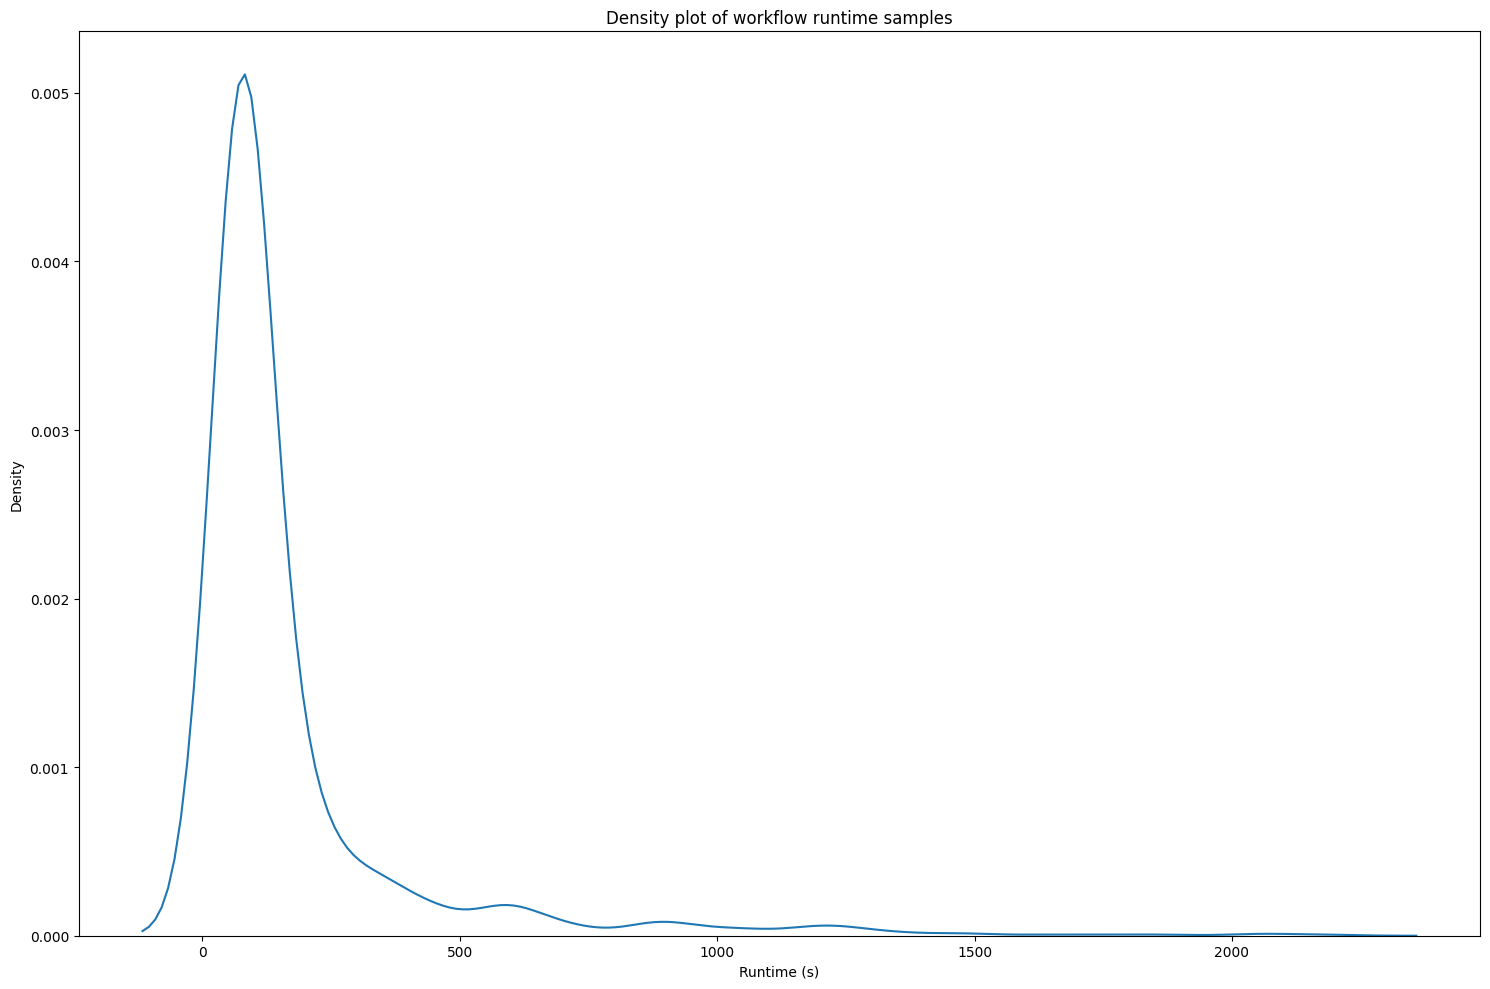

In [55]:
experiments_collected_data = f"./data/collected_workflow/{workflow_id}/experiments/data.json"


# Plot the workflow_runtime_samples as a distribution
with open(experiments_collected_data, "r") as f:
    data = json.load(f)

workflow_runtime_samples = data["workflow_runtime_samples"]

# Plot this list of values as a distribution
fig, ax = plt.subplots(figsize=(15, 10))

sns.histplot(workflow_runtime_samples, kde=True, ax=ax)

ax.set_title('Distribution of workflow runtime samples')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Frequency')

# Make y axis log scale
ax.set_yscale('log')

plt.tight_layout()
result_file_name = f"./data/plots/workflow_runtime_distribution_{workflow_id}.png"
plt.savefig(result_file_name, dpi=300)

# Plot the workflow_runtime_samples as a density plot
fig, ax = plt.subplots(figsize=(15, 10))

sns.kdeplot(workflow_runtime_samples, ax=ax)

ax.set_title('Density plot of workflow runtime samples')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Density')

plt.tight_layout()
result_file_name = f"./data/plots/workflow_runtime_density_{workflow_id}.png"
plt.savefig(result_file_name, dpi=300)

In [50]:
from multi_x_serverless.routing.deployment_input.components.calculators.carbon_calculator import CarbonCalculator
from multi_x_serverless.routing.deployment_input.components.loaders.carbon_loader import CarbonLoader
from multi_x_serverless.routing.deployment_input.components.loaders.datacenter_loader import DatacenterLoader
from multi_x_serverless.routing.deployment_input.components.calculators.runtime_calculator import RuntimeCalculator

from multi_x_serverless.common.models.endpoints import Endpoints
from multi_x_serverless.routing.deployment_input.components.loaders.workflow_loader import WorkflowLoader
from unittest.mock import MagicMock, patch
from multi_x_serverless.common.constants import DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE
from multi_x_serverless.routing.workflow_config import WorkflowConfig
from copy import deepcopy

result_data_points = {}

deployment_result_path = f'./data/deployment_results/{workflow_id}/'
experiments_collected_data_dir = f"./data/collected_workflow/{workflow_id}/experiments"

endpoints = Endpoints()

def calculate_carbon_of_deployment_at_time(deployment, date, hour_of_day):
    def get_carbon_data():
        real_available_regions = list(locations.keys())
        loaded_carbon_data = {}
        for region in real_available_regions:
            carbon_data_path = f'./data/collected_carbon/{region}/{date}/data.json'
            with open(carbon_data_path, 'r') as file:
                loaded_carbon_data[f'aws:{region}'] = json.load(file)
        return loaded_carbon_data
    
    def get_workflow_data():
        collected_data_dir = experiments_collected_data_dir + f"/data.json"

        with open(collected_data_dir, "r") as f:
            workflow_data = json.load(f)
        return workflow_data

    workflow_config_from_table = endpoints.get_data_collector_client().get_value_from_table(
        DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE, workflow_id
    )

    workflow_json = json.loads(workflow_config_from_table)
    
    workflow_config_dict = json.loads(workflow_json["workflow_config"])

    workflow_config = WorkflowConfig(workflow_config_dict)

    carbon_loader = CarbonLoader(None)
    datacenter_loader = DatacenterLoader(endpoints.get_data_collector_client())
    datacenter_loader.setup(list(f"aws:{region}" for region in locations.keys()))
    workflow_loader = WorkflowLoader(None, workflow_config)
    carbon_calculator = CarbonCalculator(carbon_loader, datacenter_loader, workflow_loader, None)

    workflow_loader._workflow_data = get_workflow_data()
    carbon_loader._carbon_data = get_carbon_data()

    carbon_calculator.alter_carbon_setting(hour_of_day)

    total_execution_carbon = 0
    total_transmission_carbon = 0
    for instance_name, provider_region in deployment.items():
        provider_region_str = f"{provider_region['provider_region']['provider']}:{provider_region['provider_region']['region']}"
        total_execution_carbon_per_instance = 0
        for execution_latency in workflow_loader._workflow_data["instance_summary"][instance_name]["executions"][provider_region_str]:
            total_execution_carbon_per_instance += carbon_calculator.calculate_execution_carbon(instance_name, provider_region_str, execution_latency)

        avg_execution_carbon_per_instance_for_this_day = total_execution_carbon_per_instance / len(workflow_loader._workflow_data["instance_summary"][instance_name]["executions"][provider_region_str])
        total_execution_carbon += avg_execution_carbon_per_instance_for_this_day

        if instance_name == benchmark_to_start_hop_instance[workflow_id]:
            # We need to add the transmission carbon for the start hop
            avg_transfer_carbon_for_this_day = 0
            number_of_data = 0
            for transfer_size, transfer_latencies in workflow_loader._workflow_data["start_hop_summary"][provider_region_str].items():
                for transfer_latency in transfer_latencies:
                    avg_transfer_carbon_for_this_day += carbon_calculator.calculate_transmission_carbon(workflow_config.home_region, provider_region_str, float(transfer_size), transfer_latency)
                    number_of_data += 1
            avg_transfer_carbon_for_this_day /= number_of_data

            total_transmission_carbon += avg_transfer_carbon_for_this_day

        for to_instance, to_instance_data in workflow_loader._workflow_data["instance_summary"][instance_name]["to_instance"].items():
            total_from_to_transfer_carbon = 0
            number_of_data = 0
            from_region = provider_region_str
            to_region = f"{deployment[to_instance]['provider_region']['provider']}:{deployment[to_instance]['provider_region']['region']}"
            transfer_size_to_transfer_latencies = to_instance_data["regions_to_regions"][from_region][to_region]["transfer_size_to_transfer_latencies"]
            for transfer_size, transfer_latencies in transfer_size_to_transfer_latencies.items():
                for transfer_latency in transfer_latencies:
                    total_from_to_transfer_carbon += carbon_calculator.calculate_transmission_carbon(from_region, to_region, float(transfer_size), transfer_latency)
                    number_of_data += 1
            avg_transfer_carbon_for_this_day = total_from_to_transfer_carbon / number_of_data

            total_transmission_carbon += avg_transfer_carbon_for_this_day
    
    return {"total_execution_carbon": total_execution_carbon, "total_transmission_carbon": total_transmission_carbon}

region_to_deployment = {}

loaded_single_region_data = False

for directory in os.listdir(deployment_result_path):
    if not os.path.isdir(os.path.join(deployment_result_path, directory)):
        continue
    result_data_points[directory] = []

    for file in os.listdir(os.path.join(deployment_result_path, directory)):
        day_date = file.split(".")[0]

        day_datetime = datetime.strptime(day_date, "%Y-%m-%d").replace(tzinfo=GLOBAL_TIME_ZONE)

        if day_datetime < start_date or day_datetime > end_date:
            continue

        with open(os.path.join(deployment_result_path, directory, file), 'r') as f:
            data = json.load(f)

        for time_key, deployment in data["time_keys_to_staging_area_data"].items():
            calculated_carbon = calculate_carbon_of_deployment_at_time(deployment, day_date, time_key)
            datetime_of_result = day_datetime + timedelta(hours=int(time_key))
            result_data_points[directory].append({
                "carbon_intensity": calculated_carbon["total_execution_carbon"] + calculated_carbon["total_transmission_carbon"],
                "total_execution_carbon": calculated_carbon["total_execution_carbon"],
                "total_transmission_carbon": calculated_carbon["total_transmission_carbon"],
                "date": datetime_of_result.strftime("%Y-%m-%d:%H")
            })

            if not loaded_single_region_data:
                for region in locations.keys():
                    if region not in result_data_points:
                        result_data_points[region] = []

                    if region not in region_to_deployment:
                        deployment_copy = deepcopy(deployment)

                        for instance_name, instance_data in deployment_copy.items():
                            instance_data["provider_region"] = {"provider": "aws", "region": region}

                        region_to_deployment[region] = deployment_copy

                    region_calculated_carbon = calculate_carbon_of_deployment_at_time(region_to_deployment[region], day_date, time_key)

                    result_data_points[region].append({
                        "carbon_intensity": region_calculated_carbon["total_execution_carbon"] + region_calculated_carbon["total_transmission_carbon"],
                        "total_execution_carbon": region_calculated_carbon["total_execution_carbon"],
                        "total_transmission_carbon": region_calculated_carbon["total_transmission_carbon"],
                        "date": datetime_of_result.strftime("%Y-%m-%d:%H")
                    })

    loaded_single_region_data = True

# Store the result data points
with open(f'./data/deployment_results/{workflow_id}/result_data_points.json', 'w') as f:
    json.dump(result_data_points, f, indent=4)

### Plot the data

/var/folders/52/5xjfl_6j78gccywqdq5v40k00000gp/T/ipykernel_36394/3636367834.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df], ignore_index=True)


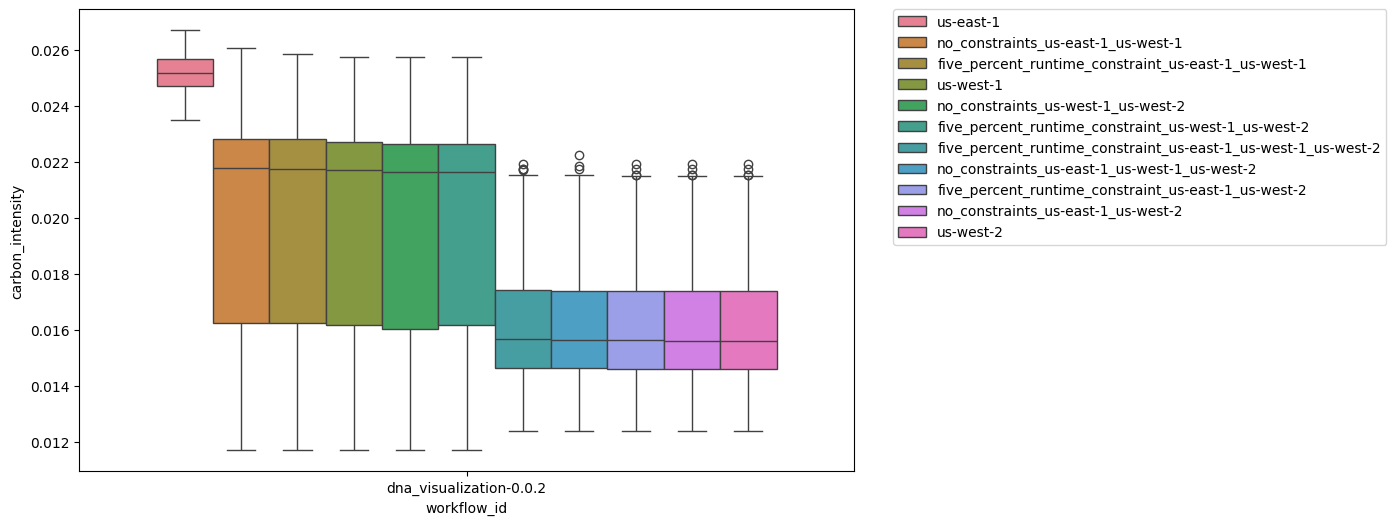

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty DataFrame to store all data
all_data = pd.DataFrame(columns=["workflow_id", "key", "carbon_intensity"])

for workflow_id in benchmarks:
    with open(f'./data/deployment_results/{workflow_id}/result_data_points.json', 'r') as f:
        result_data_points = json.load(f)

    # For each key in the data, append the data (carbon intensity) for that key to the DataFrame
    for key, data in result_data_points.items():
        df = pd.DataFrame({
            "workflow_id": [workflow_id] * len(data),
            "key": [key] * len(data),
            "carbon_intensity": [entry["carbon_intensity"] for entry in data],
        })

        all_data = pd.concat([all_data, df], ignore_index=True)

plt.figure(figsize=(10, 6))

key_order = all_data.groupby("key")["carbon_intensity"].median().sort_values(ascending=False).index
# Plot all the data in the same plot
sns.boxplot(x="workflow_id", y="carbon_intensity", hue="key", data=all_data, hue_order=key_order)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

os.makedirs("./data/plots", exist_ok=True)
included_regions_str = "_".join(locations.keys())
included_benchmarks_str = "_".join(benchmarks)
result_file_name = f"./data/plots/comparative_plot_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}_{included_regions_str}_{included_benchmarks_str}.png"
plt.savefig(result_file_name, dpi=300, bbox_inches='tight')

/Users/viktorgsteiger/Library/Caches/pypoetry/virtualenvs/multi-x-serverless-RxvPqp3n-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


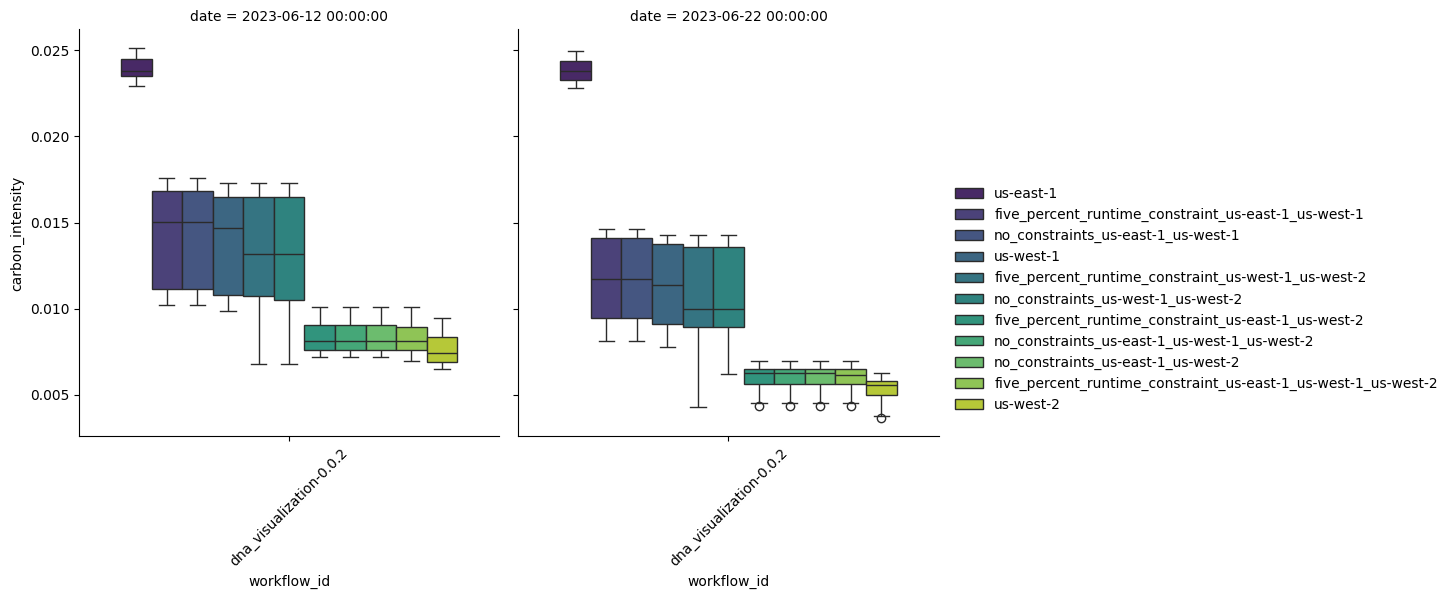

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from datetime import datetime

# Create an empty DataFrame to store all data
all_data = pd.DataFrame()

for workflow_id in benchmarks:
    with open(f'./data/deployment_results/{workflow_id}/result_data_points.json', 'r') as f:
        result_data_points = json.load(f)

    # Append the data for each key to the DataFrame
    for key, data in result_data_points.items():
        df = pd.DataFrame({
            "workflow_id": [workflow_id] * len(data),
            "key": [key] * len(data),
            "carbon_intensity": [entry["carbon_intensity"] for entry in data],
            "date": [datetime.strptime(entry["date"], "%Y-%m-%d:%H").strftime("%Y-%m-%d") for entry in data]
        })

        all_data = pd.concat([all_data, df], ignore_index=True)

# Convert 'date' to datetime to ensure it's in the correct format
all_data['date'] = pd.to_datetime(all_data['date'])

# Filter for the 12.06 and 22.06
all_data = all_data[(all_data['date'].dt.date == datetime(2023, 6, 12).date()) | (all_data['date'].dt.date == datetime(2023, 6, 22).date())]

# Now, create a FacetGrid to plot a separate boxplot for each day
g = sns.FacetGrid(all_data, col="date", col_wrap=2, height=5, sharey=True)
key_order = all_data.groupby("key")["carbon_intensity"].median().sort_values(ascending=False).index
g.map(sns.boxplot, "workflow_id", "carbon_intensity", "key", palette="viridis", hue_order=key_order)

# Additional customization for readability
g.set_xticklabels(rotation=45)
g.add_legend()

# Saving the plot
os.makedirs("./data/plots", exist_ok=True)
included_regions_str = "_".join(locations.keys())
included_benchmarks_str = "_".join(benchmarks)
result_file_name = f"./data/plots/daily_comparative_plot_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}_{included_regions_str}_{included_benchmarks_str}.png"
plt.savefig(result_file_name, dpi=300)

plt.show()

/var/folders/52/5xjfl_6j78gccywqdq5v40k00000gp/T/ipykernel_22216/654737228.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df], ignore_index=True)
/var/folders/52/5xjfl_6j78gccywqdq5v40k00000gp/T/ipykernel_22216/654737228.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


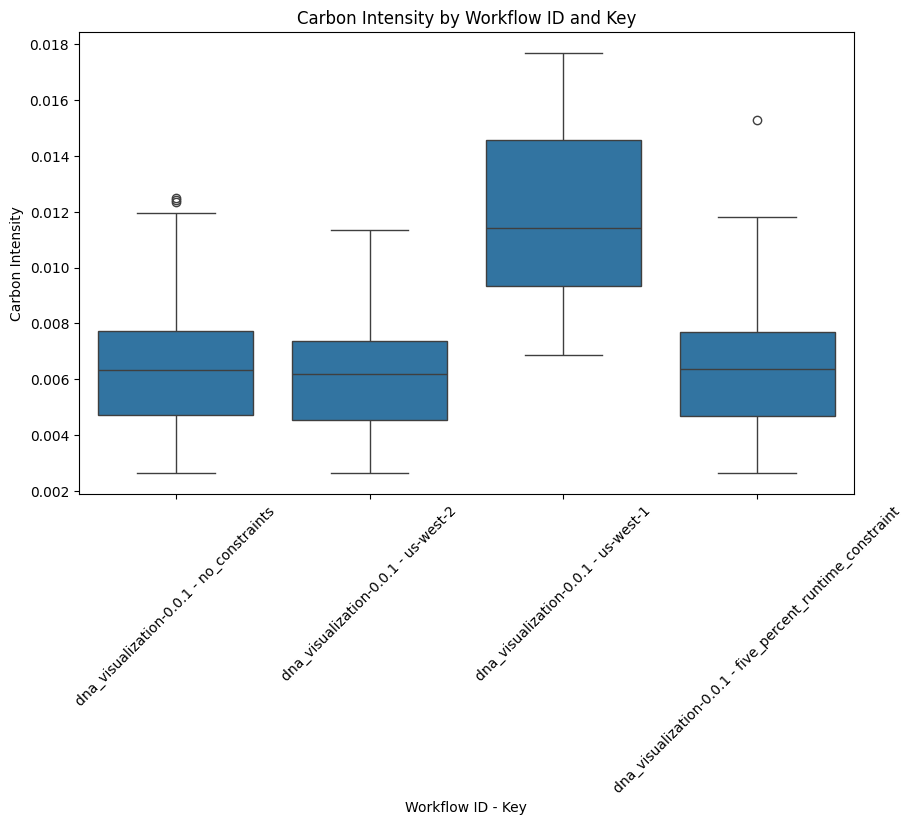

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty DataFrame to store all data
all_data = pd.DataFrame(columns=["workflow_id", "key", "carbon_intensity", "time_key"])

for workflow_id in benchmarks:
    with open(f'./data/deployment_results/{workflow_id}/result_data_points.json', 'r') as f:
        result_data_points = json.load(f)

    # For each key in the data, append the data (carbon intensity) for that key to the DataFrame
    for key, data in result_data_points.items():
        df = pd.DataFrame({
            "workflow_id": [workflow_id] * len(data),
            "key": [key] * len(data),
            "carbon_intensity": [entry["carbon_intensity"] for entry in data],
            "time_key": [entry["time_key"] for entry in data]
        })

        all_data = pd.concat([all_data, df], ignore_index=True)

# Combine 'workflow_id' and 'key' into a single categorical variable for plotting
all_data['workflow_key'] = all_data['workflow_id'].astype(str) + " - " + all_data['key']

# Plot all the data in the same plot using the new 'workflow_key' for the x-axis
plt.figure(figsize=(10, 6))  # Optionally adjust the figure size
ax = sns.boxplot(x="workflow_key", y="carbon_intensity", data=all_data)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Optionally, you can adjust labels and title
ax.set_xlabel("Workflow ID - Key")
ax.set_ylabel("Carbon Intensity")
ax.set_title("Carbon Intensity by Workflow ID and Key")

plt.show()